In [1]:
# Import libraries
import ephem
import math
import datetime
import geopy
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from matplotlib.ticker import FuncFormatter
import numpy as np

In [2]:
# Get retina display quality for plots
%config InlineBackend.figure_format = 'retina'

In [3]:
# Set up observer
home = ephem.Observer()

In [4]:
# Change date to desired date
home.date = '2019-01-01'

In [5]:
# Change city name to get location coordinates or insert them manualy, in degrees
city = 'Sao Paulo'

gn = geopy.geocoders.GeoNames(username="mrbits")

location = gn.geocode("Sao Paulo")

# To set location manualy, comment the two lines bellow and uncomment the other two.
# Set latitude and logitude in degrees
home.lat = str(location.latitude)
home.lon = str(location.longitude)

# home.lat = -23.6
# home.lon = -46-6

In [6]:
# Setup the Sun
sun = ephem.Sun()
sun.compute(home)

In [9]:
# Compute Rising, Transit (solar noon) and set
rising = home.previous_rising(sun).datetime()
print('Sunrise is at {:02}:{:02}:{:02}'.format(rising.hour -3 , rising.minute, rising.second))

transit = home.next_transit(sun).datetime()
print('Local noon is at {:02}:{:02}:{:02}'.format(transit.hour - 3 , transit.minute, transit.second))

setting = home.next_setting(sun).datetime()
print('Sunset is at {:02}:{:02}:{:02}'.format(setting.hour - 3, setting.minute, setting.second))

Sunrise is at 05:22:18
Local noon is at 12:10:02
Sunset is at 18:57:02


In [9]:
import ephem
dates = "2019"

print("All times in UTC. Seasons relative to Southern Hemisphere.")
print("==========================================================")
print("Autumnal Equinox: {0}".format(ephem.next_vernal_equinox(date)))
print("Winter Solstice: {0}".format(ephem.next_summer_solstice(dates['vernal_equinox_start'])))
print("Spring Equinox: {0}".format(ephem.next_autumnal_equinox(dates['vernal_equinox_start'])))
print("Summer Solstice: {0}".format(ephem.next_winter_solstice(dates['vernal_equinox_start'])))

All times in UTC. Seasons relative to Southern Hemisphere.
Autumnal Equinox: 2019/3/20 21:58:31


TypeError: string indices must be integers

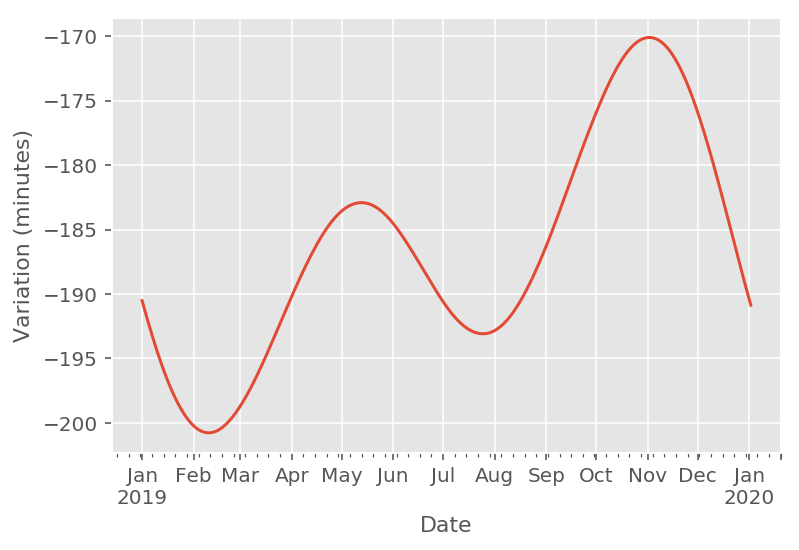

In [8]:
# Aparent Solar Time
matplotlib.style.use('ggplot')

# Prepare
times = []

def get_diff(tm):
    """Return a difference in seconds between tm and 12:00:00 on tm's date"""
    a = datetime.datetime.combine(tm, datetime.time(12, 0))
    return (a-tm).total_seconds()/60

# Prepare the data
for i in range(1, 368):
    home.date += ephem.Date(1)
    trans = home.next_transit(sun).datetime()
    times.append(get_diff(trans))

# Set up
ts = pd.Series(times, index=pd.date_range("2019-01-01", periods=len(times)))

# Plot graph
ax = ts.plot()
plt.rcParams["figure.figsize"] = [9, 6]
ax.set_xlabel(u'Date', fontsize=11)
ax.set_ylabel(u'Variation (minutes)', fontsize=11)
# Fire
plt.show()

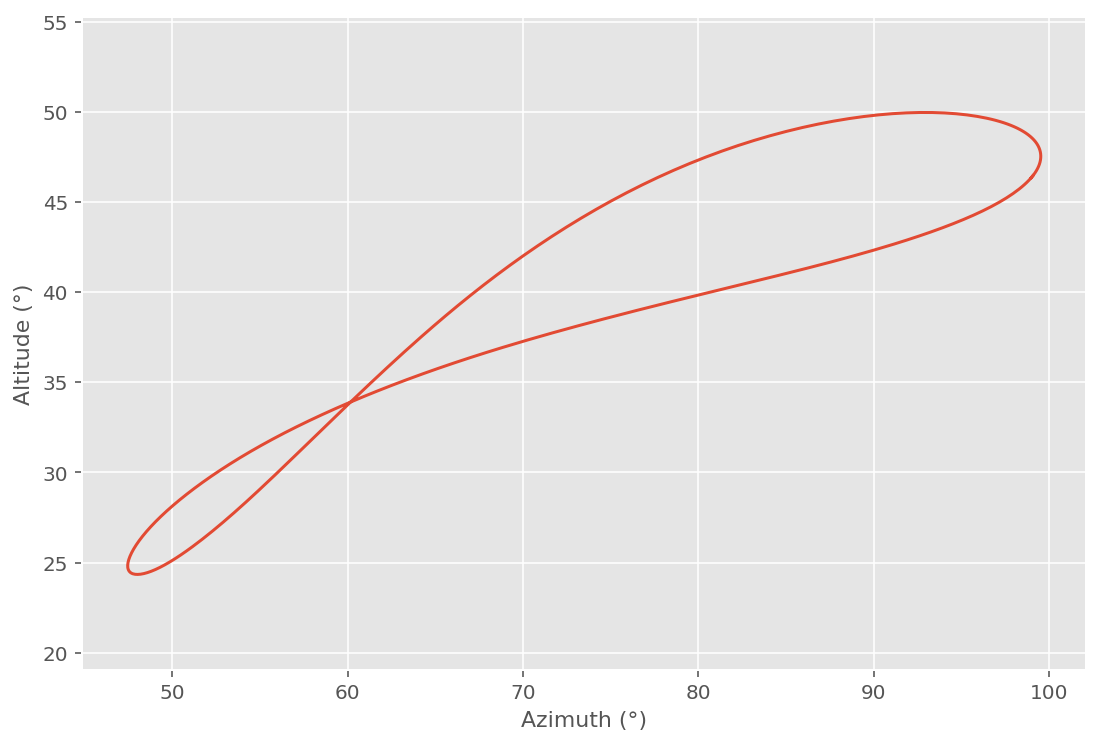

In [9]:
# Drawing Analemma
home.date = '2019/01/01 12:00:00'
home.horizon = 0
sun = ephem.Sun()
posx = []
posy = []

# Solstice altitude
phi = 90 - math.degrees(home.lat)
# Earth axial tilt
epsilon = 23.439

def get_sun_az(tm):
    """Get the azimuth based on a date"""
    sun.compute(tm)
    return math.degrees(sun.az)

def get_sun_alt(tm):
    """Get the altitude based on a date"""
    sun.compute(tm)
    return math.degrees(sun.alt)

# Prepare the data
for i in range(1, 368):
    home.date += ephem.Date(1)
    trans = home.next_transit(sun).datetime()
    posx.append(get_sun_az(home))
    posy.append(get_sun_alt(home))

# Set up
fig, ax = plt.subplots()
ax.plot(posx, posy)
ax.grid(True)
ax.set_xlabel(u'Azimuth (°)', fontsize=11)
ax.set_ylabel(u'Altitude (°)', fontsize=11)
plt.rcParams["figure.figsize"] = [9, 6]

plot_margin = 4
x0, x1, y0, y1 = plt.axis()
plt.axis((x0, x1, y0 - plot_margin, y1 + plot_margin))

# Fire
plt.show()

In [10]:
# Twilights
# Computed by default in Ephem using Sun Edge, not center
# Difference between Edge and Center can be calculated as
initial_set = home.next_setting(sun).datetime() # zero edge
next_set = home.next_setting(sun, use_center=True).datetime() # zero centre

print('Centre sunset is at {}:{}:{}'.format(next_set.hour, next_set.minute, next_set.second))
print('Edge sunset is at {}:{}:{}'.format(initial_set.hour, initial_set.minute, initial_set.second))

delta = initial_set - next_set
print('Time difference is {} mins, {} secs'.format(delta.seconds/60, delta.seconds%60))


def get_setting_twilights(obs, body):
    """Returns a list of twilight datetimes in epoch format"""
    results = []
    # Twilights, their horizons and whether to use the centre of the Sun or not
    twilights = [('0', False), ('-6', True), ('-12', True), ('-18', True)]
    for twi in twilights:
        # Zero the horizon
        obs.horizon = twi[0]
        try:
            # Get the setting time and date
            now = obs.next_setting(body, use_center=twi[1]).datetime()
            # Get seconds elapsed since midnight
            results.append(
                (now - now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
            )
        except ephem.AlwaysUpError:
            # There will be occasions where the sun stays up, make that max seconds
            results.append(86400.0)
    return results

home.horizon = '0'
twilights = get_setting_twilights(home, sun)
twilights

Centre sunset is at 21:55:54
Edge sunset is at 21:57:31
Time difference is 1.6 mins, 36 secs


[79051.158074, 80592.561694, 82360.17966, 84249.264551]

In [11]:
# Preparing data
twidataset = []

# Calculate just over a year of data
for i in range(1, 368):
    home.date += ephem.Date(1)
    twidataset.append(get_setting_twilights(home, sun))

In [12]:
# Plot list as a Pandas Dataframe
df = pd.DataFrame(twidataset, columns=['Sunset', 'Civil', 'Nautical', 'Astronomical'])

df[150:160]

# Data is ready

,Sunset,Civil,Nautical,Astronomical
150,73660.248814,75156.230982,76792.166758,78445.861607
151,73655.739476,75153.194387,76790.537428,78445.494021
152,73652.339184,75151.196889,76789.880446,78446.038544
153,73650.041997,75150.230500,76790.185358,78447.484052
154,73648.841157,75150.286537,76791.442002,78449.817902
155,73648.728964,75151.355256,76793.638376,78453.026469
156,73649.696580,75153.426063,76796.762232,78457.095732
157,73651.733797,75156.486959,76800.799884,78462.010508
158,73654.828818,75160.524535,76805.736016,78467.754104
159,73658.968203,75165.523861,76811.554534,78474.308468


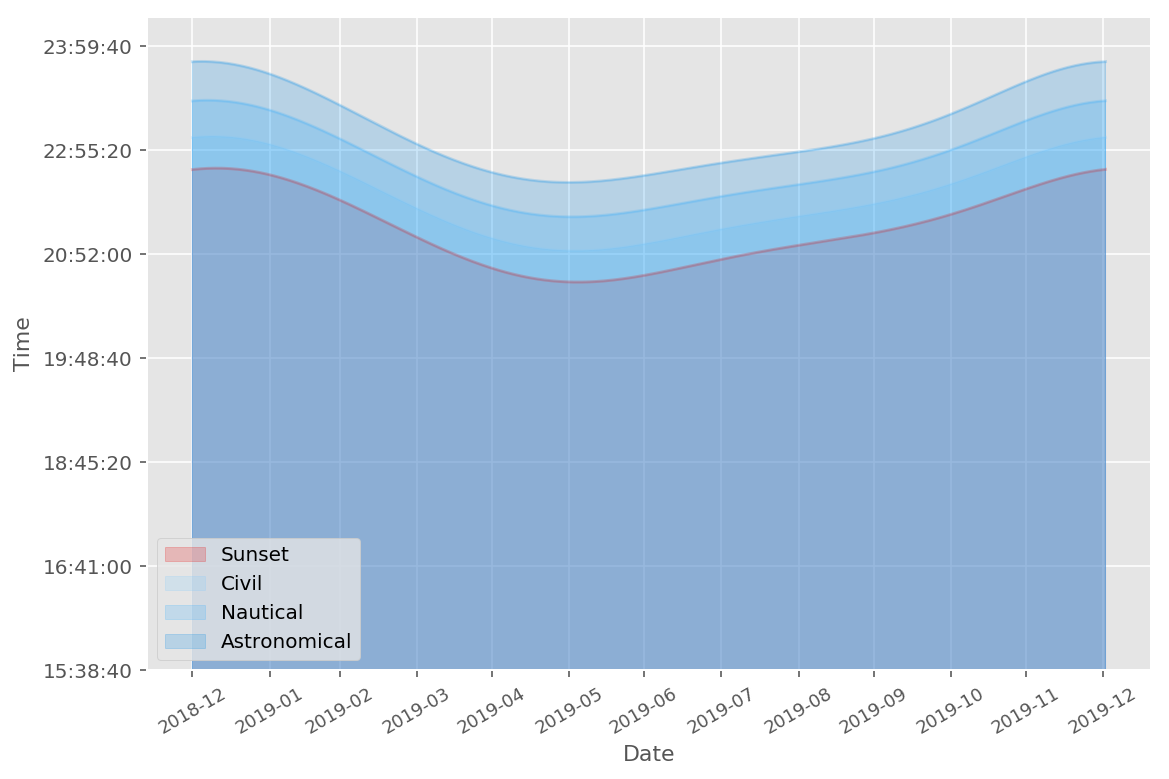

In [13]:
# Plot Graph
def timeformatter(x, pos):
    """The two args are the value and tick position"""
    return '{}:{}:{:02d}'.format(int(x/3600), int(x/24/60), int(x%60))

def dateformatter(x, pos):
    """The two args are the value and tick position"""
    dto = datetime.date.fromordinal(datetime.date(2019, 1, 1).toordinal() + int(x) - 1)
    return '{}-{:02d}'.format(dto.year, dto.month)

plt.rcParams["figure.figsize"] = [9, 6]
ax = df.plot.area(stacked=False, color=['#e60000', '#80ccff', '#33adff', '#008ae6'], alpha=0.2)
# Sort out x-axis
# Demarcate months
dim = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
ax.xaxis.set_ticks(np.cumsum(dim))
ax.xaxis.set_major_formatter(FuncFormatter(dateformatter))
ax.set_xlabel(u'Date', fontsize=11)
# Sort out y-axis
ax.yaxis.set_major_formatter(FuncFormatter(timeformatter))
ax.set_ylim([55000, 86400])
ax.set_ylabel(u'Time', fontsize=11)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=9)
# Done
plt.show()

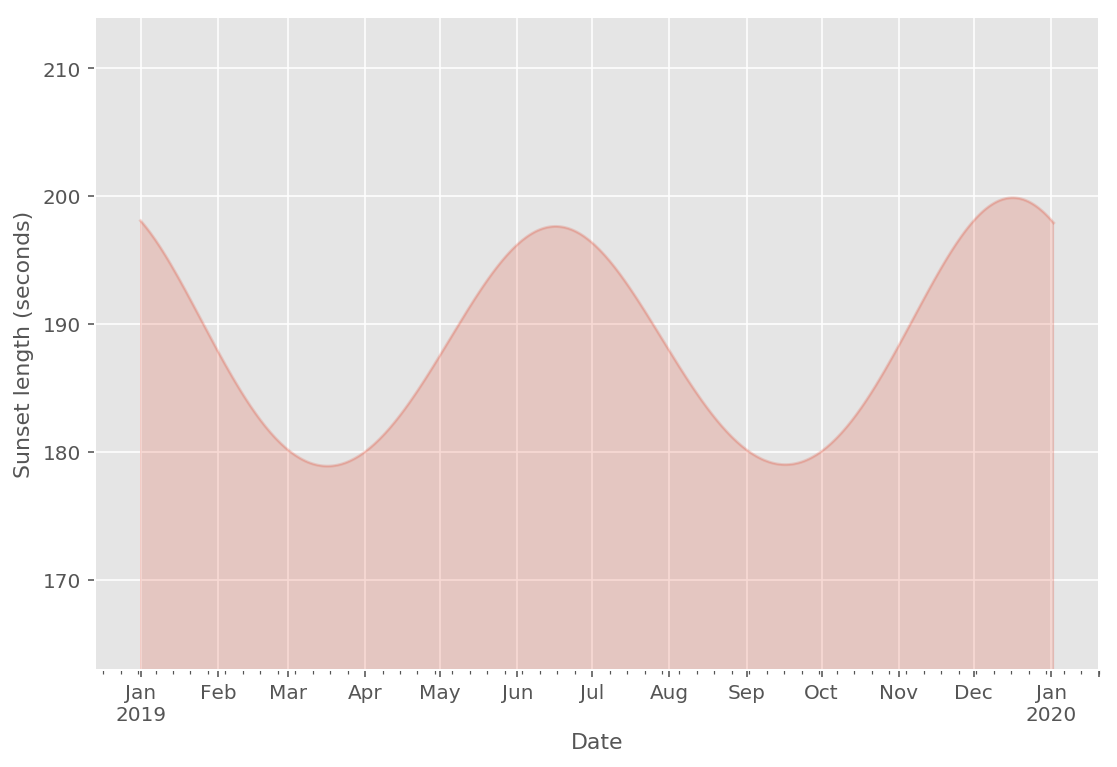

In [14]:
# Sunset length
settings = []

for i in range(1, 368):
    home.date += ephem.Date(1)
    home.horizon = '0'
    start = home.next_setting(sun, use_center=False).datetime()
    home.horizon = '-0.53'
    end = home.next_setting(sun, use_center=False).datetime()
    settings.append((end - start).total_seconds())
    
ts = pd.Series(settings, index=pd.date_range('2019/1/1', periods=len(settings)))

ax = ts.plot.area(alpha=0.2)
plt.rcParams["figure.figsize"] = [9, 6]
ax.set_xlabel(u'Date', fontsize=11)
ax.set_ylabel(u'Sunset length (seconds)', fontsize=11)
ax.set_ylim([math.floor(ts.min()) - 15, math.floor(ts.max()) + 15])
# Fire
plt.show()